In [2]:
using Dates

using HTTP
using JSON
using TimeSeries
using MarketData
using Plots

pyplot()

Plots.PyPlotBackend()

In [3]:
const API_KEY = "ECHCOU9TU74L412C"

function intraday_time_series(ticker)
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=$ticker&interval=1min&outputsize=full&apikey=$API_KEY"
    req = HTTP.request("GET", url)
    return JSON.parse(String(req.body))
end

intraday_time_series (generic function with 1 method)

In [4]:
function intraday_json_to_time_array(time_series)
    ts = time_series["Time Series (1min)"]

    df = DateFormat("yyyy-mm-dd HH:MM:SS")
    times = sort([Dates.DateTime(dt, df) for dt in keys(ts)])
    time_keys = [Dates.format(dt, df) for dt in times]  # Same as keys(ts) but sorted

    open  = [parse(Float64, ts[dt]["1. open"])  for dt in time_keys]
    high  = [parse(Float64, ts[dt]["2. high"])  for dt in time_keys]
    low   = [parse(Float64, ts[dt]["3. low"])   for dt in time_keys]
    close = [parse(Float64, ts[dt]["4. close"]) for dt in time_keys]

    data = (datetime=times, open=open, high=high, low=low, close=close)
    return TimeArray(data, timestamp=:datetime)
end

intraday_json_to_time_array (generic function with 1 method)

In [5]:
SPY = intraday_time_series("SPY")
ts = intraday_json_to_time_array(SPY)

1943×4 TimeArray{Float64,2,DateTime,Array{Float64,2}} 2020-04-01T09:31:00 to 2020-04-07T16:00:00
│                     │ open    │ high     │ low      │ close    │
├─────────────────────┼─────────┼──────────┼──────────┼──────────┤
│ 2020-04-01T09:31:00 │ 247.98  │ 248.19   │ 247.77   │ 247.87   │
│ 2020-04-01T09:34:00 │ 248.06  │ 248.31   │ 247.73   │ 247.9    │
│ 2020-04-01T09:35:00 │ 247.9   │ 248.39   │ 247.8934 │ 248.35   │
│ 2020-04-01T09:36:00 │ 248.34  │ 248.37   │ 247.74   │ 248.14   │
│ 2020-04-01T09:37:00 │ 248.12  │ 249.29   │ 248.07   │ 249.06   │
│ 2020-04-01T09:38:00 │ 249.05  │ 249.8    │ 249.04   │ 249.49   │
│ 2020-04-01T09:39:00 │ 249.48  │ 249.8    │ 249.26   │ 249.36   │
│ 2020-04-01T09:40:00 │ 249.35  │ 249.51   │ 248.88   │ 249.0269 │
│ 2020-04-01T09:41:00 │ 249.02  │ 249.24   │ 248.62   │ 248.9104 │
│ 2020-04-01T09:42:00 │ 248.91  │ 249.14   │ 248.725  │ 249.14   │
│ 2020-04-01T09:43:00 │ 249.135 │ 249.79   │ 249.1    │ 249.615  │
│ 2020-04-01T09:44:00 │ 249.615 

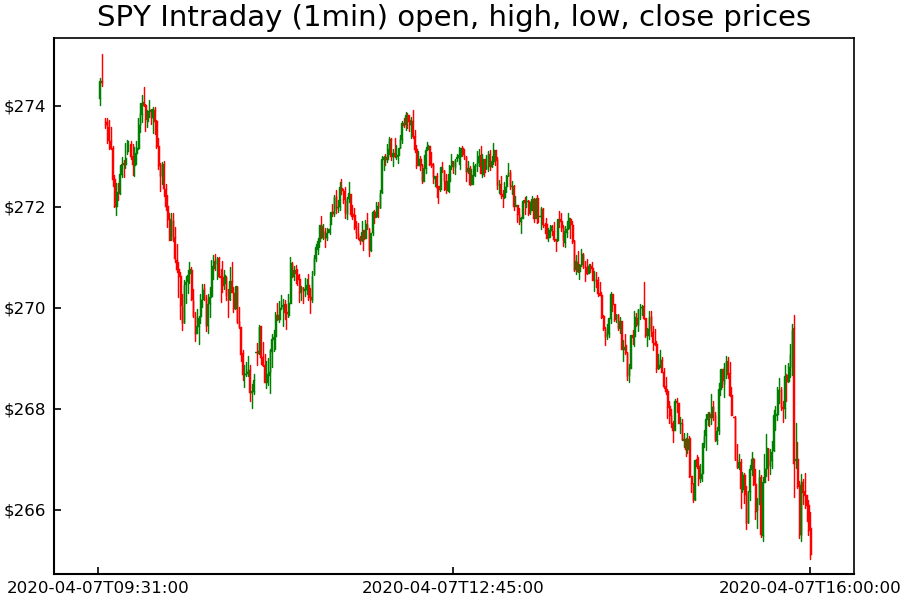

In [9]:
sub_ts = ts[end-388:end]
plot(sub_ts, seriestype=:candlestick, color=[:red, :green],
     title="SPY Intraday (1min) open, high, low, close prices",
     xticks=[timestamp(sub_ts)[1], timestamp(sub_ts)[round(Int, end/2)], timestamp(sub_ts)[end]],
     yformatter=y->"\$$(Int(y))", framestyle=:box, dpi=150)

In [10]:
# data = (datetime=timestamp(sub_ts), prediction=264 .+ randn(51))
# pred_ts = TimeArray(data, timestamp=:datetime)
# plot!(pred_ts, color=:blue)

In [11]:
using Gen

In [12]:
import LinearAlgebra

"""Node in a tree representing a covariance function"""
abstract type Kernel end
abstract type PrimitiveKernel <: Kernel end
abstract type CompositeKernel <: Kernel end

"""
    size(::Kernel)
Number of nodes in the tree describing this kernel.
"""
Base.size(::PrimitiveKernel) = 1
Base.size(node::CompositeKernel) = node.size

"""Constant kernel"""
struct Constant <: PrimitiveKernel
    param::Float64
end


eval_cov(node::Constant, x1, x2) = node.param

function eval_cov_mat(node::Constant, xs::Vector{Float64})
    n = length(xs)
    fill(node.param, (n, n))
end


"""Linear kernel"""
struct Linear <: PrimitiveKernel
    param::Float64
end


eval_cov(node::Linear, x1, x2) = (x1 - node.param) * (x2 - node.param)

function eval_cov_mat(node::Linear, xs::Vector{Float64})
    xs_minus_param = xs .- node.param
    xs_minus_param * xs_minus_param'
end


"""Squared exponential kernel"""
struct SquaredExponential <: PrimitiveKernel
    length_scale::Float64
end


eval_cov(node::SquaredExponential, x1, x2) =
    exp(-0.5 * (x1 - x2) * (x1 - x2) / node.length_scale)

function eval_cov_mat(node::SquaredExponential, xs::Vector{Float64})
    diff = xs .- xs'
    exp.(-0.5 .* diff .* diff ./ node.length_scale)
end


"""Periodic kernel"""
struct Periodic <: PrimitiveKernel
    scale::Float64
    period::Float64
end


function eval_cov(node::Periodic, x1, x2)
    freq = 2 * pi / node.period
    exp((-1/node.scale) * (sin(freq * abs(x1 - x2)))^2)
end


function eval_cov_mat(node::Periodic, xs::Vector{Float64})
    freq = 2 * pi / node.period
    abs_diff = abs.(xs .- xs')
    exp.((-1/node.scale) .* (sin.(freq .* abs_diff)).^2)
end


"""Plus node"""
struct Plus <: CompositeKernel
    left::Kernel
    right::Kernel
    size::Int
end


Plus(left, right) = Plus(left, right, size(left) + size(right) + 1)


function eval_cov(node::Plus, x1, x2)
    eval_cov(node.left, x1, x2) + eval_cov(node.right, x1, x2)
end


function eval_cov_mat(node::Plus, xs::Vector{Float64})
    eval_cov_mat(node.left, xs) .+ eval_cov_mat(node.right, xs)
end


"""Times node"""
struct Times <: CompositeKernel
    left::Kernel
    right::Kernel
    size::Int
end


Times(left, right) = Times(left, right, size(left) + size(right) + 1)


function eval_cov(node::Times, x1, x2)
    eval_cov(node.left, x1, x2) * eval_cov(node.right, x1, x2)
end


function eval_cov_mat(node::Times, xs::Vector{Float64})
    eval_cov_mat(node.left, xs) .* eval_cov_mat(node.right, xs)
end

eval_cov_mat (generic function with 6 methods)

In [14]:


"""Compute covariance matrix by evaluating function on each pair of inputs."""
function compute_cov_matrix(covariance_fn::Kernel, noise, xs)
    n = length(xs)
    cov_matrix = Matrix{Float64}(undef, n, n)
    for i=1:n
        for j=1:n
            cov_matrix[i, j] = eval_cov(covariance_fn, xs[i], xs[j])
        end
        cov_matrix[i, i] += noise
    end
    return cov_matrix
end


"""Compute covariance function by recursively computing covariance matrices."""
function compute_cov_matrix_vectorized(covariance_fn, noise, xs)
    n = length(xs)
    eval_cov_mat(covariance_fn, xs) + Matrix(noise * LinearAlgebra.I, n, n)
end

"""
Computes the conditional mean and covariance of a Gaussian process with prior mean zero
and prior covariance function `covariance_fn`, conditioned on noisy observations
`Normal(f(xs), noise * I) = ys`, evaluated at the points `new_xs`.
"""
function compute_predictive(covariance_fn::Kernel, noise::Float64,
                            xs::Vector{Float64}, ys::Vector{Float64},
                            new_xs::Vector{Float64})
    n_prev = length(xs)
    n_new = length(new_xs)
    means = zeros(n_prev + n_new)
    cov_matrix = compute_cov_matrix(covariance_fn, noise, vcat(xs, new_xs))
    cov_matrix_11 = cov_matrix[1:n_prev, 1:n_prev]
    cov_matrix_22 = cov_matrix[n_prev+1:n_prev+n_new, n_prev+1:n_prev+n_new]
    cov_matrix_12 = cov_matrix[1:n_prev, n_prev+1:n_prev+n_new]
    cov_matrix_21 = cov_matrix[n_prev+1:n_prev+n_new, 1:n_prev]
    @assert cov_matrix_12 == cov_matrix_21'
    mu1 = means[1:n_prev]
    mu2 = means[n_prev+1:n_prev+n_new]
    conditional_mu = mu2 + cov_matrix_21 * (cov_matrix_11 \ (ys - mu1))
    conditional_cov_matrix = cov_matrix_22 - cov_matrix_21 * (cov_matrix_11 \ cov_matrix_12)
    conditional_cov_matrix = 0.5 * conditional_cov_matrix + 0.5 * conditional_cov_matrix'
    (conditional_mu, conditional_cov_matrix)
end

"""
Predict output values for some new input values
"""
function predict_ys(covariance_fn::Kernel, noise::Float64,
                    xs::Vector{Float64}, ys::Vector{Float64},
                    new_xs::Vector{Float64})
    (conditional_mu, conditional_cov_matrix) = compute_predictive(
        covariance_fn, noise, xs, ys, new_xs)
    mvnormal(conditional_mu, conditional_cov_matrix)
end

predict_ys

In [15]:
kernel_types = [Constant, Linear, SquaredExponential, Periodic, Plus, Times]
@dist choose_kernel_type() = kernel_types[categorical([0.2, 0.2, 0.2, 0.2, 0.1, 0.1])];

In [16]:
# Prior on kernels
@gen function covariance_prior()
    # Choose a type of kernel
    kernel_type ~ choose_kernel_type()

    # If this is a composite node, recursively generate subtrees
    if in(kernel_type, [Plus, Times])
        return kernel_type({:left} ~ covariance_prior(), {:right} ~ covariance_prior())
    end
    
    # Otherwise, generate parameters for the primitive kernel.
    kernel_args = (kernel_type == Periodic) ? [{:scale} ~ uniform(0, 1), {:period} ~ uniform(0, 1)] : [{:param} ~ uniform(0, 1)]
    return kernel_type(kernel_args...)
end

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[], false, Union{Nothing, Some{Any}}[], ##covariance_prior#408, Bool[], false)

In [17]:
for i=1:10
    println(covariance_prior())
end

Linear(0.07242080955007535)
Periodic(0.6043075172617982, 0.6290489385706937)
Constant(0.12010441583350495)
Periodic(0.5913874645696631, 0.6973141991200031)
SquaredExponential(0.522565871334723)
Periodic(0.656818876591621, 0.7175232708847528)
SquaredExponential(0.9980127477658831)
Constant(0.7930409547237078)
Times(Linear(0.8455105760121358), Plus(Times(Periodic(0.06257669277919686, 0.7908610473697222), SquaredExponential(0.23600338895150896), 3), SquaredExponential(0.7633018679944272), 5), 7)
Constant(0.0744152141585066)


In [18]:
@dist gamma_bounded_below(shape, scale, bound) = gamma(shape, scale) + bound

# Full model
@gen function model(xs::Vector{Float64})
    
    # Generate a covariance kernel
    covariance_fn = {:tree} ~ covariance_prior()
    
    # Sample a global noise level
    noise ~ gamma_bounded_below(1, 1, 0.01)
    
    # Compute the covariance between every pair (xs[i], xs[j])
    cov_matrix = compute_cov_matrix_vectorized(covariance_fn, noise, xs)
    
    # Sample from the GP using a multivariate normal distribution with
    # the kernel-derived covariance matrix.
    ys ~ mvnormal(zeros(length(xs)), cov_matrix)
    
    # Return the covariance function, for easy printing.
    return covariance_fn
end;

In [64]:
function serialize_trace(tr, xmin, xmax)
    (xs,) = get_args(tr)
    curveXs = collect(Float64, range(xmin, length=100, stop=xmax))
    curveYs = [predict_ys(get_retval(tr), 0.00001, xs, tr[:ys], curveXs) for i=1:5]
    plot(curveXs, curveYs)
end

serialize_trace (generic function with 1 method)

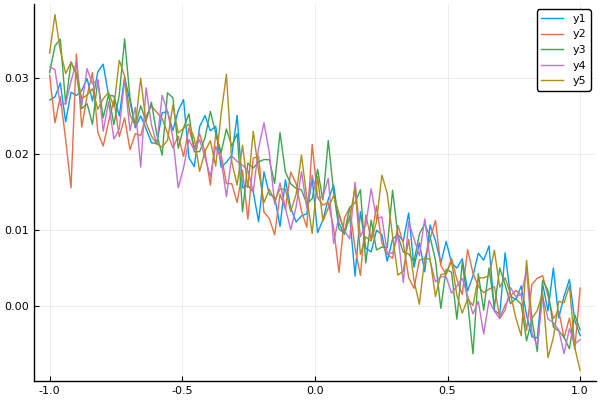

In [34]:
trace, _ = Gen.generate(model, (collect(Float64, -1:0.1:1),))
serialize_trace(trace, -1, 1)

In [31]:
function initialize_trace(xs::Vector{Float64}, ys::Vector{Float64})
    tr, = generate(model, (xs,), choicemap(:ys => ys))
    return tr
end

initialize_trace (generic function with 1 method)

In [35]:
@gen function random_node_path(n::Kernel)
    if ({:stop} ~ bernoulli(isa(n, PrimitiveKernel) ? 1.0 : 0.5))
        return :tree
    else
        (next_node, direction) = ({:left} ~ bernoulli(0.5)) ? (n.left, :left) : (n.right, :right)
        rest_of_path ~ random_node_path(next_node)
        
        if isa(rest_of_path, Pair)
            return :tree => direction => rest_of_path[2]
        else
            return :tree => direction
        end
        
    end
end;

In [39]:
example_model_trace, = generate(model, ([0.],), choicemap((:tree => :kernel_type) => Plus));
get_choices(example_model_trace)

│
├── :ys : [0.3034007629289196]
│
├── :noise : 0.5996626740682245
│
└── :tree
    │
    ├── :kernel_type : Plus
    │
    ├── :left
    │   │
    │   ├── :param : 0.6801089303292753
    │   │
    │   └── :kernel_type : Linear
    │
    └── :right
        │
        ├── :param : 0.660888719646461
        │
        └── :kernel_type : Linear


In [40]:
example_covariance_kernel = get_retval(example_model_trace)

Plus(Linear(0.6801089303292753), Linear(0.660888719646461), 3)

In [41]:
random_node_chooser_trace = simulate(random_node_path, (example_covariance_kernel,));

In [42]:
get_retval(random_node_chooser_trace)

:tree

In [44]:
get_choices(random_node_chooser_trace)

│
└── :stop : true


In [45]:
@gen function regen_random_subtree_randomness(prev_trace)
    path ~ random_node_path(get_retval(prev_trace))
    new_subtree ~ covariance_prior()
    return path
end;

In [57]:
function subtree_involution(trace, forward_choices, path_to_subtree, proposal_args)
    # Need to return a new trace, backward_choices, and a weight.
    backward_choices = choicemap()
    
    # In the backward direction, the `random_node_path` function should
    # make all the same choices, so that the same exact node is reached
    # for resimulation.
    set_submap!(backward_choices, :path, get_submap(forward_choices, :path))
    
    # But in the backward direction, the `:new_subtree` generation should
    # produce the *existing* subtree.
    set_submap!(backward_choices, :new_subtree, get_submap(get_choices(trace), :tree))
    
    # The new trace should be just like the old one, but we are updating everything
    # about the new subtree.
    new_trace_choices = choicemap()
    set_submap!(new_trace_choices, path_to_subtree, get_submap(forward_choices, :new_subtree))
    
    # Run update and get the new weight.
    new_trace, weight, = Gen.update(trace, get_args(trace), (UnknownChange(),), new_trace_choices)
    (new_trace, backward_choices, weight)
end

subtree_involution (generic function with 1 method)

In [58]:
function run_mcmc(trace, iters::Int)
    for iter=1:iters
        (trace, acc) = mh(trace, regen_random_subtree_randomness, (), subtree_involution)
        (trace, _) = mh(trace, select(:noise))
    end
    return trace
end

run_mcmc (generic function with 2 methods)

In [77]:
xs = collect(1.0:10.0)
ys = collect(1.0:10.0).^2

10-element Array{Float64,1}:
   1.0
   4.0
   9.0
  16.0
  25.0
  36.0
  49.0
  64.0
  81.0
 100.0

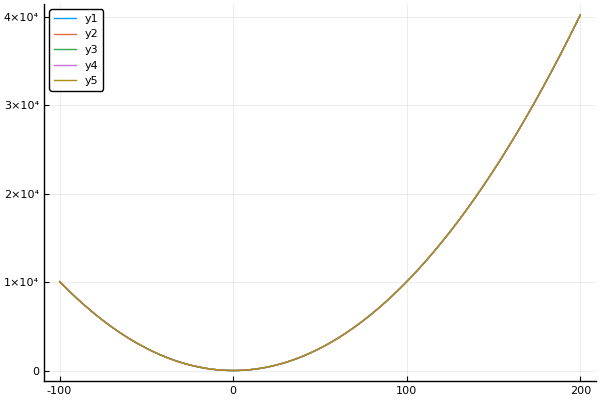

In [79]:
t = initialize_trace(xs, ys);
t = run_mcmc(t, 1000)
serialize_trace(t, -100, 200)

In [80]:
Gen.get_choices(t)

│
├── :ys : [1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0, 81.0, 100.0]
│
├── :noise : 0.016646475007816075
│
└── :tree
    │
    ├── :kernel_type : Times
    │
    ├── :left
    │   │
    │   ├── :param : 0.04475806921155123
    │   │
    │   └── :kernel_type : Linear
    │
    └── :right
        │
        ├── :param : 0.004422065428419941
        │
        └── :kernel_type : Linear


In [122]:
n_train = round(Int, length(sub_ts)/2)
xs = collect(1:n_train) .|> Float64
ys = (values(sub_ts.open) .+ values(sub_ts.close)) / 2
ys = ys[1:n_train]

t = initialize_trace(xs, ys);
t = run_mcmc(t, 2000)

Gen.get_choices(t)

│
├── :ys : [274.15, 274.3125, 274.475, 273.655, 273.64, 273.44, 273.22749999999996, 272.84799999999996, 272.2794, 272.15, 272.28, 272.455, 272.745, 272.85, 272.90139999999997, 273.20000000000005, 273.24, 273.125, 272.92499999999995, 272.945, 273.10699999999997, 273.39, 273.735, 273.945, 274.04499999999996, 273.8675, 273.79999999999995, 273.9034, 273.84000000000003, 273.85, 273.8075, 273.45, 273.015, 272.72249999999997, 272.725, 272.6, 272.17499999999995, 271.88, 271.54499999999996, 271.53, 271.57500000000005, 271.18494999999996, 270.86, 270.6895, 270.345, 269.865, 270.0725, 270.485, 270.585, 270.724, 270.46000000000004, 269.99440000000004, 269.65999999999997, 269.565, 269.71500000000003, 269.995, 270.26, 270.27495, 269.91499999999996, 269.87, 270.16005, 270.52625, 270.855, 270.89, 270.923, 270.7999, 270.61495, 270.53, 270.57, 270.41495, 270.17134999999996, 270.34749999999997, 270.41499999999996, 270.14, 270.20500000000004, 270.07000000000005, 269.6725, 269.35, 268.88689999999997, 268.

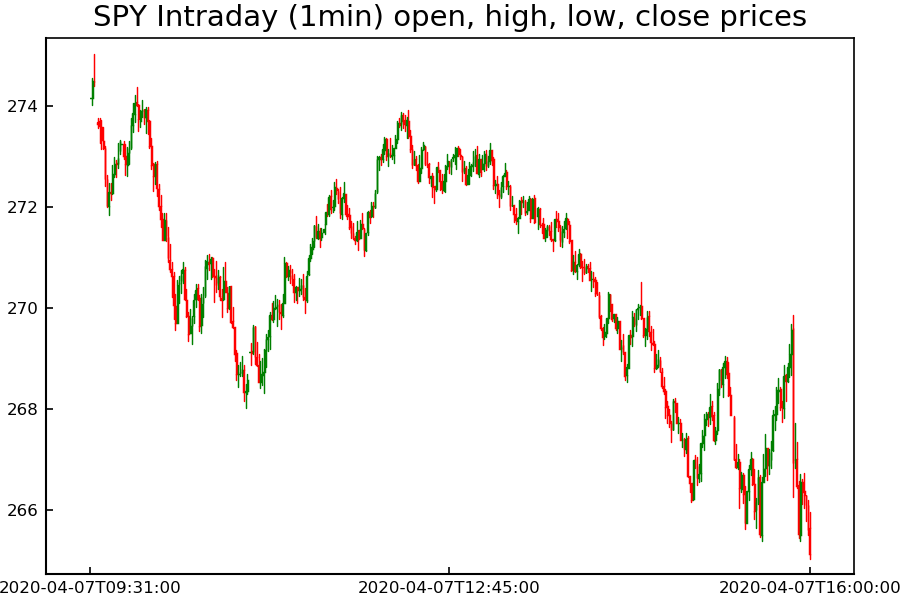

In [123]:
sub_ts = ts[end-388:end]
plot(sub_ts, seriestype=:candlestick, color=[:red, :green],
     title="SPY Intraday (1min) open, high, low, close prices",
     xticks=[timestamp(sub_ts)[1], timestamp(sub_ts)[round(Int, end/2)], timestamp(sub_ts)[end]],
     framestyle=:box, dpi=150)
     # yformatter=y->"\$$(Int(y))", framestyle=:box, dpi=150)

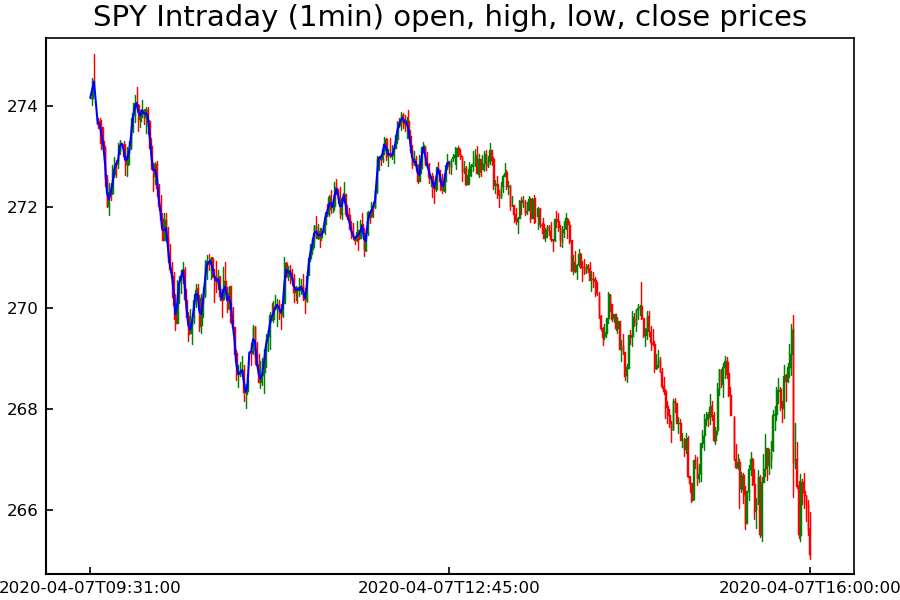

In [124]:
y_prediction = predict_ys(get_retval(t), 0.00001, xs, t[:ys], xs)

data = (datetime=timestamp(sub_ts)[1:n_train], prediction=y_prediction)
pred_ts = TimeArray(data, timestamp=:datetime)
plot!(timestamp(sub_ts)[1:n_train], y_prediction, color=:blue)

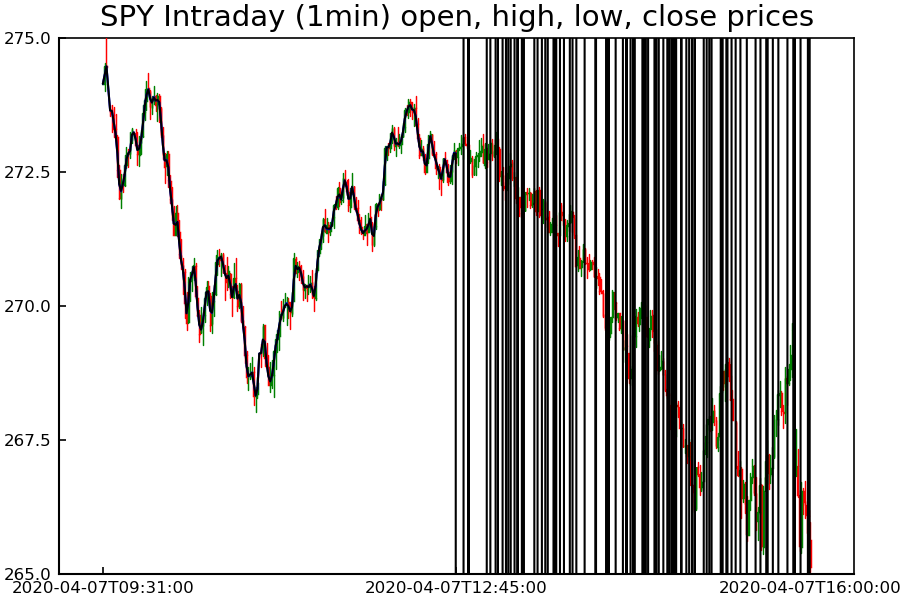

In [125]:
x_prediction = collect(1:length(sub_ts)) .|> Float64
y_prediction = predict_ys(get_retval(t), 0.00001, xs, t[:ys], x_prediction)

data = (datetime=timestamp(sub_ts), prediction=y_prediction)
pred_ts = TimeArray(data, timestamp=:datetime)
plot!(pred_ts, color=:black, ylim=(265.0, 275.0))